In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
import scipy.stats

from pycaret.regression import setup, compare_models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier

In [18]:
df = pd.read_excel('Sarah gets a diamond data..xls',header=2)
df

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169.0
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470.0
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183.0
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370.0
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171.0
...,...,...,...,...,...,...,...,...,...
5995,5996,1.03,Ideal,D,SI1,EX,EX,GIA,NaN
5996,5997,1.00,Very Good,D,SI1,VG,VG,GIA,NaN
5997,5998,1.02,Ideal,D,SI1,EX,EX,GIA,NaN
5998,5999,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,NaN


In [19]:
# Let's split data on train and test as we know first 4500 rows is train data
train_0 = df.head(4500)

# Extract the last 1500 rows as test data
test_0 = df.tail(1500)

In [20]:
train_0

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169.0
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470.0
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183.0
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370.0
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171.0
...,...,...,...,...,...,...,...,...,...
4495,4496,0.90,Very Good,F,SI1,VG,VG,GIA,4095.0
4496,4497,1.01,Good,I,SI1,VG,VG,GIA,4078.0
4497,4498,0.90,Very Good,D,SI1,VG,G,GIA,4497.0
4498,4499,1.21,Very Good,G,SI1,VG,VG,GIA,6439.0


In [21]:
test_0

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
4500,4501,1.08,Very Good,F,VS2,G,VG,GIA,NaN
4501,4502,1.12,Very Good,E,VS1,ID,ID,AGSL,NaN
4502,4503,2.20,Very Good,G,VS2,EX,EX,GIA,NaN
4503,4504,0.90,Very Good,I,SI1,VG,VG,GIA,NaN
4504,4505,0.76,Very Good,E,VS2,EX,EX,GIA,NaN
...,...,...,...,...,...,...,...,...,...
5995,5996,1.03,Ideal,D,SI1,EX,EX,GIA,NaN
5996,5997,1.00,Very Good,D,SI1,VG,VG,GIA,NaN
5997,5998,1.02,Ideal,D,SI1,EX,EX,GIA,NaN
5998,5999,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,NaN


In [22]:
#Let's check null values
train_0.isna().sum()

ID              0
Carat Weight    0
Cut             0
Color           1
Clarity         0
Polish          0
Symmetry        0
Report          0
Price           0
dtype: int64

In [23]:
test_0.isna().sum()

ID                 0
Carat Weight       0
Cut                0
Color              0
Clarity            0
Polish             0
Symmetry           1
Report             0
Price           1500
dtype: int64

### Combine train and test sets

In [24]:
target = train_0['Price']
test_ids = test_0['ID']

train1 = train_0.drop(['ID','Price'], axis = 1)
test1 = test_0.drop(['ID','Price'], axis = 1)

data1 = pd.concat([train1,test1], axis=0).reset_index(drop=True)
data1

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
0,1.10,Ideal,H,SI1,VG,EX,GIA
1,0.83,Ideal,H,VS1,ID,ID,AGSL
2,0.85,Ideal,H,SI1,EX,EX,GIA
3,0.91,Ideal,E,SI1,VG,VG,GIA
4,0.83,Ideal,G,SI1,EX,EX,GIA
...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA
5996,1.00,Very Good,D,SI1,VG,VG,GIA
5997,1.02,Ideal,D,SI1,EX,EX,GIA
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA


### Missing value handling

In [25]:
for column in data1.columns[1:]:
    unique_values = data1[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for Cut: ['Ideal' 'Very Good' 'Fair' 'Good' 'Signature-Ideal' '-' 'Ideallll'
 'ssssssssss']
Unique values for Color: ['H' 'E' 'G' 'D' 'F' 'I' nan '-']
Unique values for Clarity: ['SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'IF' 'FL' ' ']
Unique values for Polish: ['VG' 'ID' 'EX' 'G' 'НД']
Unique values for Symmetry: ['EX' 'ID' 'VG' 'G' '  ' nan]
Unique values for Report: ['GIA' 'AGSL']


In [ ]:
# Lets create variable to collect our indexes so we can drop them if needed from both - data and target.

In [26]:
indexes = []

In [27]:
data1[data1['Cut']=='-'].index

Int64Index([1061, 5722], dtype='int64')

In [28]:
indexes.extend(data1[data1['Cut']=='-'].index)

In [30]:
data1.drop(data1[(data1['Cut'] == '-') & (data1.index < 4500)].index, inplace=True)

In [31]:
data1[data1['Cut']=='ssssssssss']

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
1994,1.01,ssssssssss,G,SI1,VG,G,GIA


In [32]:
indexes.extend(data1[data1['Cut']=='ssssssssss'].index)

In [33]:
data1.drop(data1[(data1['Cut']=='ssssssssss') & (data1.index < 4500)].index, inplace=True)

In [34]:
data1[data1['Cut']=='Ideallll']

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
1219,1.67,Ideallll,D,SI1,G,VG,GIA


In [35]:
data1['Cut'].replace('Ideallll', 'Ideal', inplace=True)

In [36]:
data1[data1['Color']=='-']

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
5614,1.22,Ideal,-,VS2,VG,EX,GIA


In [37]:
indexes.extend(data1[data1['Color']=='-'].index)

In [38]:
data1.drop(data1[(data1['Color']=='-') & (data1.index < 4500)].index, inplace=True)

In [39]:
data1[data1['Clarity']==' ']

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
5492,2.01,Very Good,F,,EX,VG,GIA


In [40]:
indexes.extend(data1[data1['Clarity']==' '].index)

In [41]:
data1.drop(data1[(data1['Clarity']==' ') & (data1.index < 4500)].index, inplace=True)

In [42]:
data1[data1['Symmetry']=='  ']

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
949,2.16,Ideal,F,VS2,G,,GIA


In [43]:
indexes.extend(data1[data1['Symmetry']=='  '].index)

In [44]:
data1.drop(data1[data1['Symmetry']=='  '].index, inplace=True)

In [45]:
data1[data1['Polish']=='НД']

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
571,1.06,Very Good,H,SI1,НД,VG,GIA


In [46]:
indexes.extend(data1[data1['Polish']=='НД'].index)

In [47]:
data1.drop(data1[data1['Polish']=='НД'].index, inplace=True)

In [48]:
len(data1)

5996

In [49]:
indexes

[1061, 5722, 1994, 5614, 5492, 949, 571]

In [ ]:
# lets drop only indexes from train data(0-4500)

In [50]:
target.drop([idx for idx in indexes if idx <= len(target)], inplace=True)

In [51]:
indexes

[1061, 5722, 1994, 5614, 5492, 949, 571]

In [52]:
data1

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
0,1.10,Ideal,H,SI1,VG,EX,GIA
1,0.83,Ideal,H,VS1,ID,ID,AGSL
2,0.85,Ideal,H,SI1,EX,EX,GIA
3,0.91,Ideal,E,SI1,VG,VG,GIA
4,0.83,Ideal,G,SI1,EX,EX,GIA
...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA
5996,1.00,Very Good,D,SI1,VG,VG,GIA
5997,1.02,Ideal,D,SI1,EX,EX,GIA
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA


In [53]:
target

0        5169.0
1        3470.0
2        3183.0
3        4370.0
4        3171.0
         ...   
4495     4095.0
4496     4078.0
4497     4497.0
4498     6439.0
4499    12725.0
Name: Price, Length: 4496, dtype: float64

In [54]:
len(target)

4496

In [55]:
data2 = data1

In [56]:
data2


,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
0,1.10,Ideal,H,SI1,VG,EX,GIA
1,0.83,Ideal,H,VS1,ID,ID,AGSL
2,0.85,Ideal,H,SI1,EX,EX,GIA
3,0.91,Ideal,E,SI1,VG,VG,GIA
4,0.83,Ideal,G,SI1,EX,EX,GIA
...,...,...,...,...,...,...,...
5995,1.03,Ideal,D,SI1,EX,EX,GIA
5996,1.00,Very Good,D,SI1,VG,VG,GIA
5997,1.02,Ideal,D,SI1,EX,EX,GIA
5998,1.27,Signature-Ideal,G,VS1,EX,EX,GIA


In [57]:
data2.isna().sum()

Carat Weight    0
Cut             0
Color           1
Clarity         0
Polish          0
Symmetry        1
Report          0
dtype: int64

In [ ]:
# We have 2 null values.

In [58]:
data2[data2['Color'].isna()==True]

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
789,1.01,Very Good,NaN,VS1,EX,EX,GIA


In [ ]:
#Lets use mode function to fill null value for 'color'

In [59]:
most_frequent_color = data2['Color'].mode()[0]
data2['Color'].fillna(most_frequent_color, inplace=True)

In [60]:
data2.loc[789, 'Color']

'G'

In [ ]:
# did same with "Symmetry"

In [61]:
data2[data2['Symmetry'].isna()==True]

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report
5407,1.01,Very Good,I,SI1,VG,NaN,GIA


In [62]:
most_frequent_symmetry = data2['Symmetry'].mode()[0]
data2['Symmetry'].fillna(most_frequent_symmetry, inplace=True)

In [63]:
data2.loc[5407, 'Symmetry']

'VG'

In [64]:
data2.isna().sum()

Carat Weight    0
Cut             0
Color           0
Clarity         0
Polish          0
Symmetry        0
Report          0
dtype: int64

In [65]:
data2.dtypes

Carat Weight    float64
Cut              object
Color            object
Clarity          object
Polish           object
Symmetry         object
Report           object
dtype: object

### EDA 

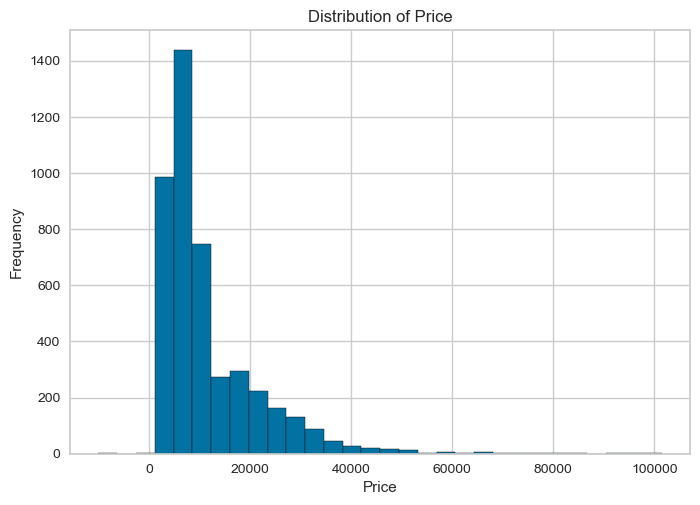

In [76]:
plt.hist(train_0['Price'], bins=30, edgecolor='black')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.show()

In [78]:
train_0[train_0["Price"]<=0]

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
1246,1247,1.12,Very Good,G,SI1,VG,G,GIA,-234.0
1349,1350,1.03,Very Good,I,SI1,VG,G,GIA,-10001.0


In [79]:
# We can see "Price" column have 2 negative values, which is not possible. We will deal with this problem later in the Notebook.
# Overall most prices under 20000$

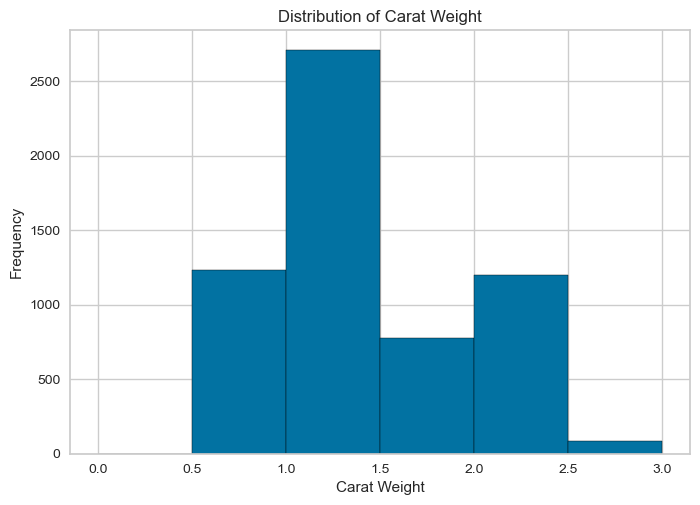

In [80]:
plt.hist(data2['Carat Weight'], bins=np.arange(0, 3.5, 0.5), edgecolor='black')
plt.title('Distribution of Carat Weight')
plt.xlabel('Carat Weight')
plt.ylabel('Frequency')
plt.show()

In [81]:
# We can see most diamonds is around 1.5 carat weight

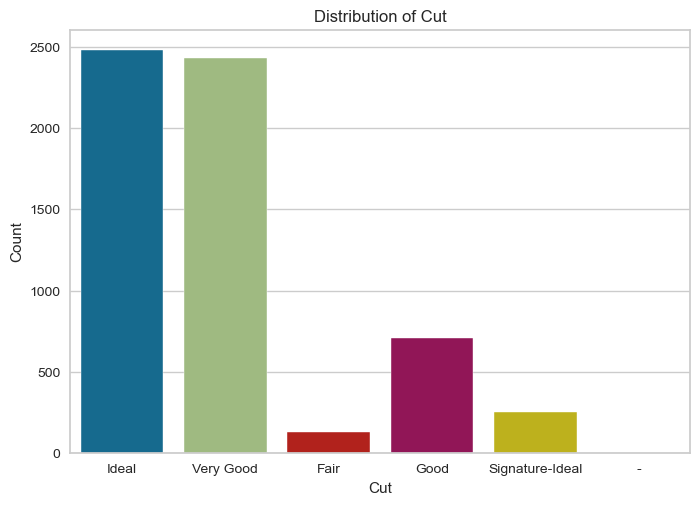

In [82]:
sns.countplot(x='Cut', data=data2)
plt.title('Distribution of Cut')
plt.xlabel('Cut')
plt.ylabel('Count')
plt.show()

In [83]:
# Based on the graph we can see most of diamonds is 'Ideal' and 'Very Good' quality. 
# We also have 1 outlier which need more attention later.

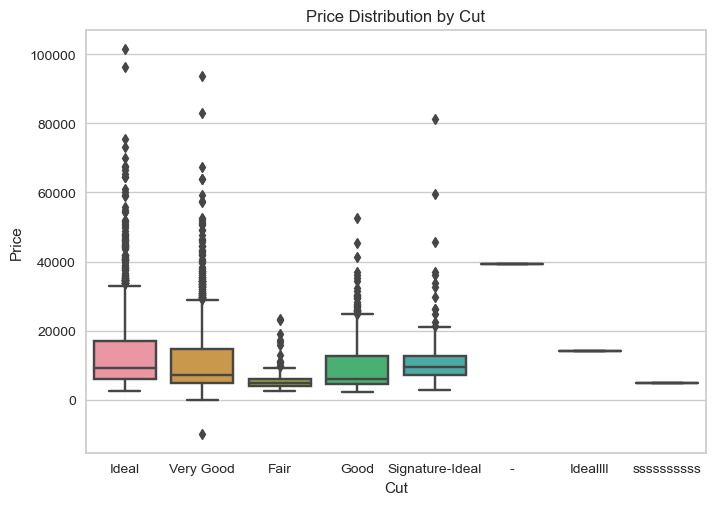

In [84]:
sns.boxplot(x='Cut', y='Price', data=train_0)
plt.title('Price Distribution by Cut')
plt.xlabel('Cut')
plt.ylabel('Price')
plt.show()

In [85]:
# We can see cut is highly correlated with price. Even though boxplot graph have a lot of outliers if you will
# look at mean you can see better cut- higher mean price.

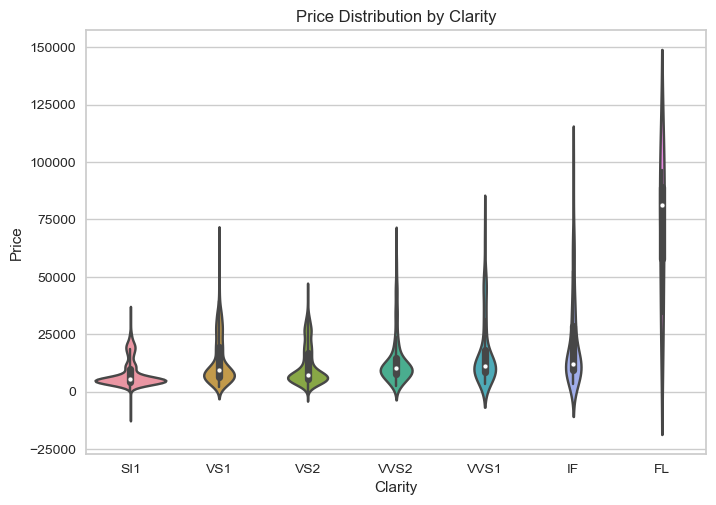

In [86]:
sns.violinplot(x='Clarity', y='Price', data=train_0)
plt.title('Price Distribution by Clarity')
plt.xlabel('Clarity')
plt.ylabel('Price')
plt.show()


In [87]:
# On this graph we clearly can see how clarity affect price. Better clarity-higher possible prices. Also Fl(flawless) and 
# IF(internally flawless) diamonds is extrimaly rare.

### Encode categorical variables

In [88]:
for column in data2.columns[1:]:
    unique_values = data2[column].unique()
    print(f"Unique values for {column}: {unique_values}")

Unique values for Cut: ['Ideal' 'Very Good' 'Fair' 'Good' 'Signature-Ideal' '-']
Unique values for Color: ['H' 'E' 'G' 'D' 'F' 'I' '-']
Unique values for Clarity: ['SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'IF' 'FL' ' ']
Unique values for Polish: ['VG' 'ID' 'EX' 'G']
Unique values for Symmetry: ['EX' 'ID' 'VG' 'G']
Unique values for Report: ['GIA' 'AGSL']


In [89]:
data3 = pd.get_dummies(data2)
data3

,Carat Weight,Cut_-,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_-,Color_D,Color_E,Color_F,Color_G,Color_H,Color_I,Clarity_,Clarity_FL,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_EX,Polish_G,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_AGSL,Report_GIA
0,1.10,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1
1,0.83,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,0.85,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,0.91,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4,0.83,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1.03,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
5996,1.00,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
5997,1.02,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
5998,1.27,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


### Scaling 

In [90]:
numerical_features = ['Carat Weight']
data3_numerical = data3[numerical_features]

In [91]:
scaler = StandardScaler()
data3_scaled = pd.DataFrame(scaler.fit_transform(data3_numerical), index=data3.index, columns=numerical_features)

data3 = pd.concat([data3_scaled, data3.drop(columns=numerical_features)], axis=1)

data3

,Carat Weight,Cut_-,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_-,Color_D,Color_E,Color_F,Color_G,Color_H,Color_I,Clarity_,Clarity_FL,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_EX,Polish_G,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_AGSL,Report_GIA
0,-0.019131,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1
1,-0.020963,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,-0.020827,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,-0.020420,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4,-0.020963,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-0.019606,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
5996,-0.019809,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
5997,-0.019674,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
5998,-0.017977,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [92]:
data4 = data3.copy()

### Target transformation

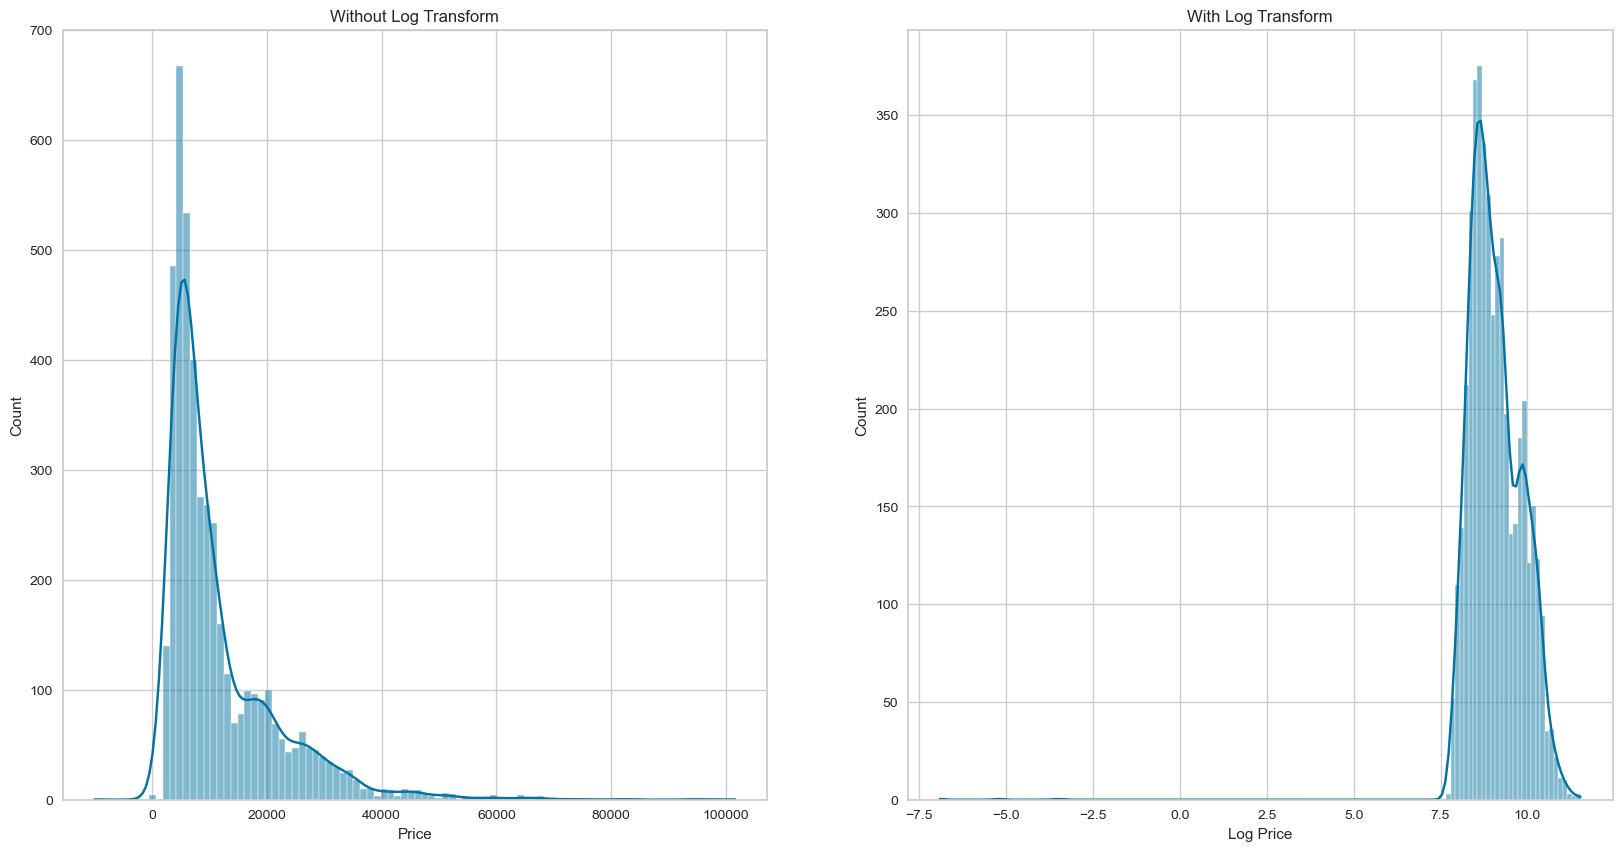

In [93]:
plt.figure(figsize=(20, 10))

# Histogram without Log Transform
plt.subplot(1, 2, 1)
sns.histplot(target, kde=True)
plt.title('Without Log Transform')

# Histogram with Log Transform
plt.subplot(1, 2, 2)
log_target = np.log(target)
sns.histplot(log_target, kde=True)
plt.xlabel('Log Price')
plt.title('With Log Transform')

plt.show()

In [94]:
len(target)

4496

In [95]:
target[target<0]

1246     -234.0
1349   -10001.0
Name: Price, dtype: float64

In [96]:
# prices cant be negative, most likely wrong data. We can
#take absolute value of this prices.

In [97]:
target[target < 0] = np.abs(target[target < 0])

In [98]:
target[target<0]

Series([], Name: Price, dtype: float64)

In [99]:
log_target = np.log(target)

In [100]:
len(log_target)

4496

### Split Data 

In [101]:
train_final = data4.loc[:train_0.index.max(),:].copy()
test_final = data4.loc[train_0.index.max()+1:,:].reset_index(drop = True).copy()

In [102]:
train_final

,Carat Weight,Cut_-,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_-,Color_D,Color_E,Color_F,Color_G,Color_H,Color_I,Clarity_,Clarity_FL,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_EX,Polish_G,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_AGSL,Report_GIA
0,-0.019131,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1
1,-0.020963,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,-0.020827,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,-0.020420,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4,-0.020963,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-0.020488,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4496,-0.019741,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4497,-0.020488,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1
4498,-0.018384,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1


In [103]:
test_final

,Carat Weight,Cut_-,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_-,Color_D,Color_E,Color_F,Color_G,Color_H,Color_I,Clarity_,Clarity_FL,Clarity_IF,Clarity_SI1,Clarity_VS1,Clarity_VS2,Clarity_VVS1,Clarity_VVS2,Polish_EX,Polish_G,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_AGSL,Report_GIA
0,-0.019266,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
1,-0.018995,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0
2,-0.011666,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
3,-0.020488,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
4,-0.021438,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-0.019606,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1496,-0.019809,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1497,-0.019674,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1498,-0.017977,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


### Model selection

In [104]:
_ = setup(data=pd.concat([train_final, log_target], axis = 1), target = 'Price')

,Description,Value
0,Session id,4879
1,Target,Price
2,Target type,Regression
3,Original data shape,"(4496, 33)"
4,Transformed data shape,"(4496, 33)"
5,Transformed train set shape,"(3147, 33)"
6,Transformed test set shape,"(1349, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


In [105]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0703,0.0654,0.1694,0.9216,0.0147,0.0085,0.2740
lightgbm,Light Gradient Boosting Machine,0.0681,0.0713,0.1902,0.9097,0.0170,0.0083,0.4720
rf,Random Forest Regressor,0.0718,0.0942,0.2270,0.8622,0.0250,0.0087,0.4290
xgboost,Extreme Gradient Boosting,0.0680,0.1180,0.2408,0.8103,0.0205,0.0083,0.3130
dt,Decision Tree Regressor,0.0879,0.1224,0.2490,0.8014,0.0201,0.0104,0.1900
et,Extra Trees Regressor,0.0770,0.1330,0.2686,0.7818,0.0237,0.0093,0.5450
ada,AdaBoost Regressor,0.1971,0.1606,0.3570,0.7339,0.0416,0.0223,0.2290
knn,K Neighbors Regressor,0.2902,0.2413,0.4757,0.5849,0.0452,0.0323,0.2000
llar,Lasso Least Angle Regression,0.5897,0.5502,0.7363,-0.0035,0.0707,0.0652,0.1880
en,Elastic Net,0.5897,0.5502,0.7363,-0.0035,0.0707,0.0652,0.1810


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

GradientBoostingRegressor(random_state=4879)

In [106]:
#Gradient Boosting Regressor

In [107]:
# Instantiate the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [108]:
# Fit the model to the training data
gb_model.fit(train_final, log_target)


GradientBoostingRegressor(random_state=42)

### Evaluate

In [109]:
kf = KFold(n_splits = 10)

results = cross_val_score(gb_model, train_final,log_target, scoring = 'neg_mean_squared_error',cv = kf)

In [110]:
results

array([-0.00696012, -0.00705683, -0.03099829, -0.90031308, -0.57935523,
       -0.00707849, -0.00679947, -0.00652433, -0.00691501, -0.00639479])

In [111]:
results.mean()

-0.15583956427615306

<Figure size 1600x1000 with 0 Axes>

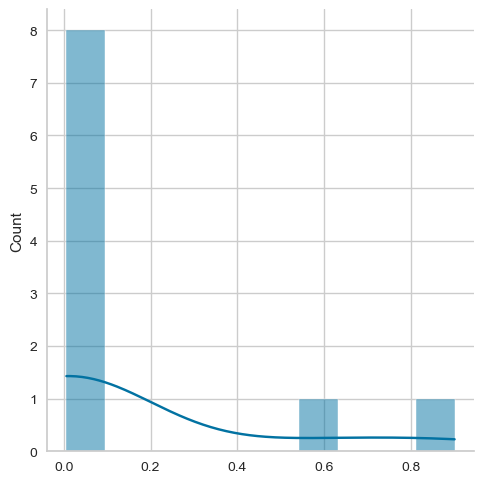

In [112]:
plt.figure(figsize= (16,10))

sns.displot (-results,bins =10, kde = True)

In [113]:
np.mean(-results)

0.15583956427615306

In [114]:
target.describe()

count      4496.000000
mean      11670.370115
std       10053.325853
min           0.001000
25%        5132.250000
50%        7871.000000
75%       14936.500000
max      101561.000000
Name: Price, dtype: float64

In [115]:
test_ids

4500    4501
4501    4502
4502    4503
4503    4504
4504    4505
        ... 
5995    5996
5996    5997
5997    5998
5998    5999
5999    6000
Name: ID, Length: 1500, dtype: int64

In [116]:
final_predictions = np.exp(gb_model.predict(test_final))

In [117]:
test_ids_reset = test_ids.reset_index(drop=True)

In [118]:
submission = pd.concat([test_ids_reset, pd.Series(final_predictions, name='Price')], axis=1)
submission

,ID,Price
0,4501,7133.083773
1,4502,8111.140698
2,4503,27942.120001
3,4504,3128.834337
4,4505,3537.075291
...,...,...
1495,5996,6302.886086
1496,5997,5179.763909
1497,5998,5946.051131
1498,5999,10665.062812


In [402]:
submission.to_csv('./submission.csv', index=False, header = True)